In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 98% 1.04G/1.06G [00:11<00:00, 65.6MB/s]
100% 1.06G/1.06G [00:11<00:00, 100MB/s] 


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
train_dir = "/content/train"
test_dir = "/content/test"

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

In [8]:
train_ds = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Classes: ['cats', 'dogs']


In [9]:
def process(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    return image, label

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [10]:
all_labels = []
for _, labels in train_ds.unbatch():
    all_labels.append(labels.numpy())

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = {i: class_weights[i] for i in range(2)}
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [11]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

In [16]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=25,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 325s 520ms/step - accuracy: 0.5416 - loss: 0.7402 - val_accuracy: 0.6564 - val_loss: 0.6240
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 326s 522ms/step - accuracy: 0.6513 - loss: 0.6251 - val_accuracy: 0.6842 - val_loss: 0.5966
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 336s 537ms/step - accuracy: 0.6642 - loss: 0.6092 - val_accuracy: 0.7224 - val_loss: 0.5623
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 371s 521ms/step - accuracy: 0.6892 - loss: 0.5979 - val_accuracy: 0.6650 - val_loss: 0.6129
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 327s 523ms/step - accuracy: 0.6939 - loss: 0.5895 - val_accuracy: 0.5616 - val_loss: 1.3326
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 330s 528ms/step - accuracy: 0.6957 - loss: 0.5877 - val_accuracy: 0.7710 - val_loss: 0.5057
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 331s 530ms/step - accuracy: 0.7027 - loss: 0.5834 - val_accuracy: 0.7594 - val_loss: 0.5112
Epoch 8/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 376s 521ms/step - accuracy: 0.7147 -

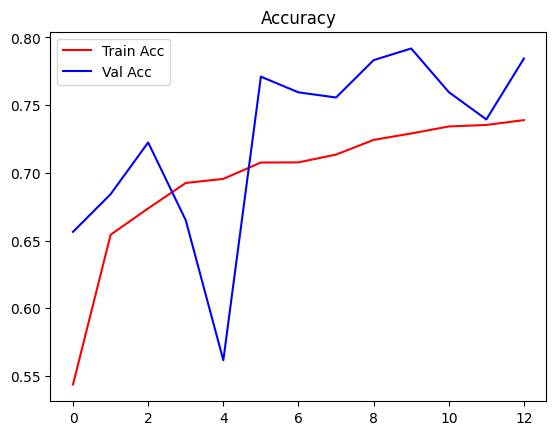

In [17]:
plt.plot(history.history['accuracy'], label='Train Acc', color='red')
plt.plot(history.history['val_accuracy'], label='Val Acc', color='blue')
plt.legend()
plt.title("Accuracy")
plt.show()

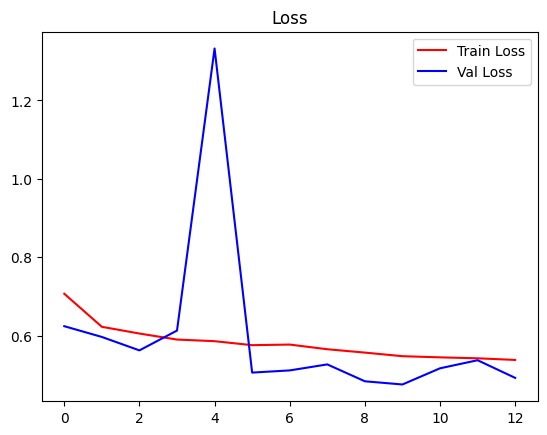

In [18]:
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Val Loss', color='blue')
plt.legend()
plt.title("Loss")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━

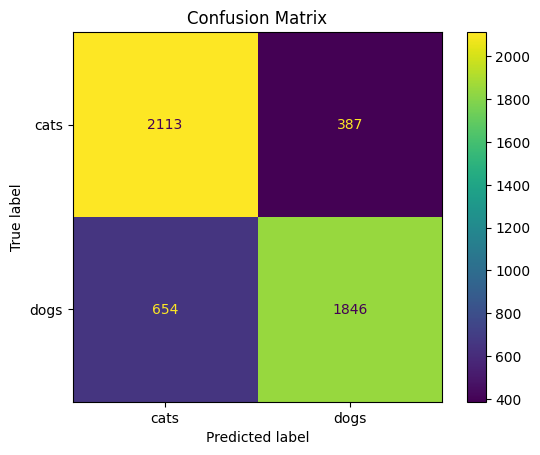

In [19]:
y_true = []
y_pred = []

for images, labels in validation_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int32").flatten())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [20]:
# Prediction function for custom images
def predict_image(image_path):

    img = cv2.imread(image_path)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction for: {image_path}")
    plt.axis('off')
    plt.show()


    img_resized = cv2.resize(img, (256, 256))
    img_input = img_resized.reshape((1, 256, 256, 3)).astype('float32') / 255.0

    pred = model.predict(img_input)[0][0]
    print("Prediction Score:", pred)
    if pred < 0.5:
        print("MY MODEL SAYS IT'S A CAT!")
    else:
        print("MY MODEL SAYS IT'S A DOG!")


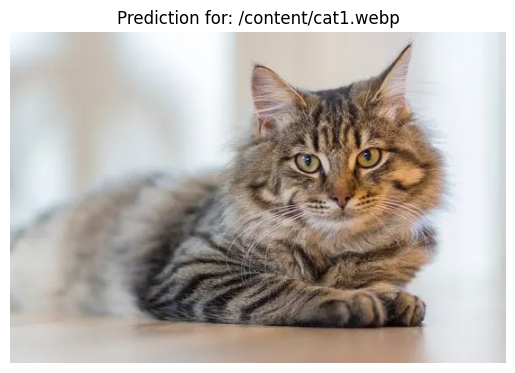

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
Prediction Score: 0.2946524
MY MODEL SAYS IT'S A CAT!


In [22]:
predict_image('/content/cat1.webp')


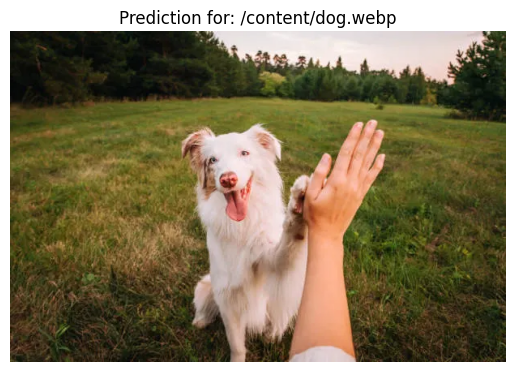

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction Score: 0.60810685
MY MODEL SAYS IT'S A DOG!


In [24]:
predict_image('/content/dog.webp')


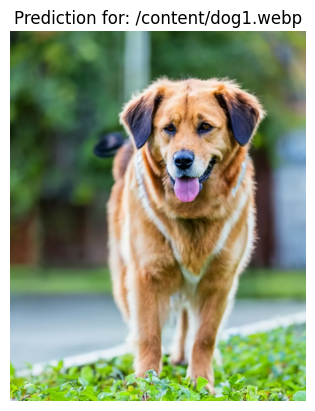

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction Score: 0.91583806
MY MODEL SAYS IT'S A DOG!


In [29]:
predict_image('/content/dog1.webp')


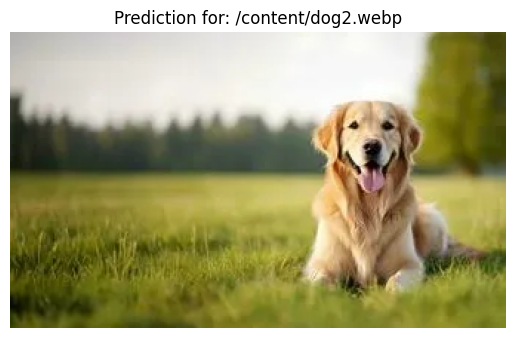

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction Score: 0.61289454
MY MODEL SAYS IT'S A DOG!


In [30]:
predict_image('/content/dog2.webp')


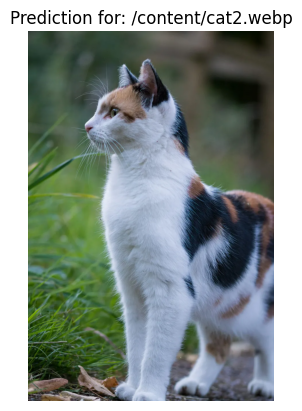

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Prediction Score: 0.2946524
MY MODEL SAYS IT'S A CAT!


In [31]:
predict_image('/content/cat2.webp')


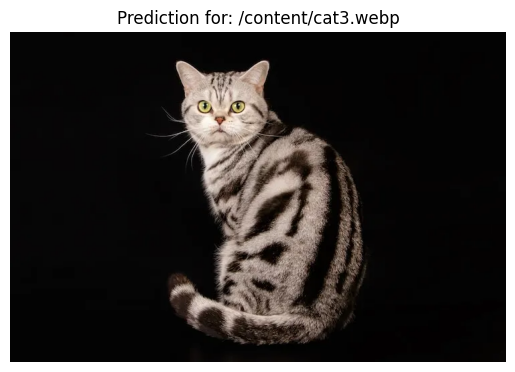

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction Score: 0.2946524
MY MODEL SAYS IT'S A CAT!


In [32]:
predict_image('/content/cat3.webp')


TO SCALE THIS PROJECT WE CAN USE GRADIO AS FOLLOWS.

In [33]:
import gradio as gr


In [34]:
def predict_gradio(image):
    # Resize image to 256x256 and normalize
    image = cv2.resize(image, (256, 256))
    image = image.astype('float32') / 255.0
    image = image.reshape(1, 256, 256, 3)

    # Predict
    pred = model.predict(image)[0][0]

    # Output label and confidence
    label = "DOG 🐶" if pred >= 0.5 else "CAT 🐱"
    confidence = f"Confidence: {pred:.4f}" if pred >= 0.5 else f"Confidence: {1 - pred:.4f}"

    return f"{label}\n{confidence}"

In [35]:
interface = gr.Interface(
    fn=predict_gradio,
    inputs=gr.Image(type="numpy", label="Upload an image"),
    outputs="text",
    title="Cat vs Dog Classifier 🐾",
    description="Upload an image of a cat or dog and see what the model predicts!"
)

# Launch it
interface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://616024c6c9bf48f577.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
